https://deepctr-doc.readthedocs.io/en/latest/

https://github.com/shenweichen/DeepCTR

# Load

In [26]:
import numpy as np
import pandas as pd

In [27]:
# Load Data
data_origin = pd.read_csv('lgb_classify.csv')

In [28]:
# Create province var
data_origin['province'] = data_origin['plate_no'].apply(lambda x:x[0])

In [29]:
# Selected needed X and Y
data_origin = data_origin.iloc[:,[3,7,8,10,11,12,14,15,16,17,18,20,21,23,24,22]].copy()

In [30]:
# Transfer all categorical dtype into object
data_origin['sex'] = data_origin['sex'].astype(object)

# Model

In [128]:
import tensorflow as tf

from deepctr.models import DeepFM
from deepctr.inputs import SparseFeat,get_feature_names, DenseFeat
import deepctr

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt

In [51]:
data = data_origin.copy()
target = 'is_return'

In [52]:
# 找出categorical和continuous
def identify_cols(data, target):
    cat_cols = []
    con_cols = []
    for col in data.columns:
        if col == target:
            pass
        elif col in data.select_dtypes(object):
            cat_cols.append(col)
        else:
            con_cols.append(col)
    return cat_cols, con_cols

sparse_features, dense_features = identify_cols(data, target)

In [53]:
# 对categorical做 Label Encoding
for feat in sparse_features:
    lbe = LabelEncoder()
    data[feat] = lbe.fit_transform(data[feat])

In [54]:
# 对continuous缩放至[0,1]范围内
mms = MinMaxScaler(feature_range=(0, 1))
data[dense_features] = mms.fit_transform(data[dense_features])

In [58]:
# 对于每个categorical_var的field计算其类别数量
# 记录每个continuous_var的field_name
fixlen_feature_columns = [
    SparseFeat(feat, 
               vocabulary_size=data[feat].nunique(),
               embedding_dim=5) # embedding_dim即Dense Embedding层的k值
    for i, feat in enumerate(sparse_features)
] + [
    DenseFeat(feat)
    for feat in dense_features
]

In [60]:
# 指定哪一部分feature进入dnn/linear部分
dnn_feature_columns = fixlen_feature_columns
linear_feature_columns = fixlen_feature_columns
feature_names = get_feature_names(linear_feature_columns + dnn_feature_columns)

In [63]:
# 产生模型使用的数据

train, test = train_test_split(data, test_size=0.2)
train_model_input = {name:train[name] for name in feature_names}
test_model_input = {name:test[name] for name in feature_names}

In [130]:
# 定义模型 + 训练
# 产生的是基于keras的模型
model = DeepFM(
    linear_feature_columns, 
    dnn_feature_columns,
    task='binary', # 二分类还是回归; 可选项为'binary'/'regression'
    dnn_hidden_units=(128, 128), # 每层的units个数。这里是两层，每层128个units
    l2_reg_linear=1e-05, # linear部分的L2正则系数
    l2_reg_embedding=1e-05, # Embedding部分的L2正则系数
    l2_reg_dnn=0, # Deep部分的L2正则系数,
    dnn_dropout=0, # Deep部分的Drop Out系数
    dnn_activation='relu', # Deep部分的激活函数
    dnn_use_bn=False, # Deep部分是否使用BatchNormalization
    seed=1024
)

model.compile(
    optimizer='adam', # 模型的优化器 | tf.keras.optimizers里的优化器小写变str
    loss='binary_crossentropy', # 模型的损失函数 | tf.losses里的损失函数小写变str
    metrics=['binary_crossentropy'] # 评估模型的metrics | 应用同上
)
# model.compile(
#     optimizer=tf.keras.optimizers.Adam(learning_rate=0.01)
#     loss='binary_crossentropy', # 模型的损失函数 | tf.losses里的损失函数小写变str
#     metrics=['binary_crossentropy'] # 评估模型的metrics | 应用同上
# )

history = model.fit(
    x=train_model_input,
    y=train[target].values,
    batch_size=64,
    epochs=10000,
    verbose=2,
    validation_split=0.2,
    # early_stop
    # 自动会检测'val_loss'并根据其类型决定是增大patience次停止还是减少patience次停止
    # patience为容忍增大/变小不动的次数范围
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                patience=10, 
                                                verbose=1)] 
)

/home/yeenlin/.conda/envs/moey_tf2/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/yeenlin/.conda/envs/moey_tf2/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 11862 samples, validate on 2966 samples
Epoch 1/10000
11862/11862 - 3s - loss: 0.5746 - binary_crossentropy: 0.5745 - val_loss: 0.5314 - val_binary_crossentropy: 0.5313
Epoch 2/10000
11862/11862 - 3s - loss: 0.5352 - binary_crossentropy: 0.5352 - val_loss: 0.5198 - val_binary_crossentropy: 0.5198
Epoch 3/10000
11862/11862 - 3s - loss: 0.5255 - binary_crossentropy: 0.5254 - val_loss: 0.5181 - val_binary_crossentropy: 0.5180
Epoch 4/10000
11862/11862 - 3s - loss: 0.5194 - binary_crossentropy: 0.5194 - val_loss: 0.5074 - val_binary_crossentropy: 0.5074
Epoch 5/10000
11862/11862 - 3s - loss: 0.5143 - binary_crossentropy: 0.5143 - val_loss: 0.5043 - val_binary_crossentropy: 0.5043
Epoch 6/10000
11862/11862 - 3s - loss: 0.5113 - binary_crossentropy: 0.5112 - val_loss: 0.5067 - val_binary_crossentropy: 0.5067
Epoch 7/10000
11862/11862 - 3s - loss: 0.5058 - binary_crossentropy: 0.5057 - val_loss: 0.4995 - val_binary_crossentropy: 0.4995
Epoch 8/10000
11862/11862 - 3s - loss: 0.5047 - 

In [118]:
# 预测 + 评估
pred_ans = model.predict(
    test_model_input,
    batch_size=None, # 如果定义模型的时候使用了BN, 则这里的batch_size需要跟训练的时候保持一致。没有使用则无所谓
)

# convert result into 1/0 by 0.5 threshold
fn = lambda x: 1 if x > 0.5 else 0
ypred = [fn(x) for x in pred_ans]

# Accuracy in test set
accuracy = accuracy_score(test[target].values,ypred)
print('Accuracy:{}'.format(accuracy))

Accuracy:0.7693552738063124


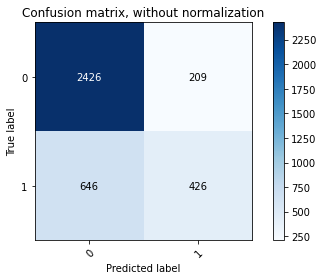

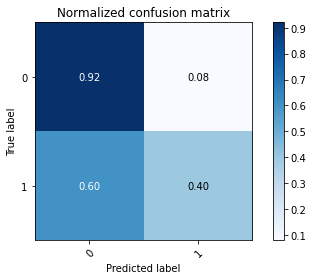

In [126]:
# Confusion-Matrix

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

classes=[0,1] # Y的类别
plot_confusion_matrix(test[target].values, ypred, classes, normalize=False)
plot_confusion_matrix(test[target].values, ypred, classes, normalize=True)
plt.show()

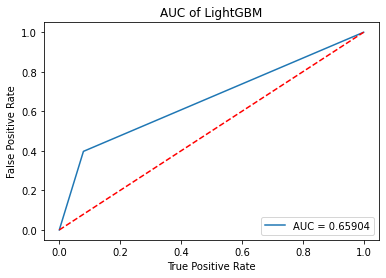

In [129]:
# AUC Plot

def plot_auc(y_true, y_pred):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    auc = roc_auc_score(y_true,y_pred)
    plt.plot(fpr, tpr,label = 'AUC = {:1.5f}'.format(auc))
    plt.legend(loc = 4)
    plt.plot([0,1],[0,1],'r--')
    plt.title('AUC of LightGBM')
    plt.xlabel('True Positive Rate')
    plt.ylabel('False Positive Rate')
    plt.show()

plot_auc(test[target].values, ypred)

In [131]:
# 使用该包除了DeepFM还有很多DeepCTR的模型。
# 可以后续再尝试。

In [134]:
type(train_model_input)

dict